# Stage 6d — Old vs New Captain Picker Comparison

**Objective**: Compare captain selections between the old pipeline's Algorithm strategy and the new pipeline's regret-optimal policy.

## Setup

| Aspect | Old Pipeline | New Pipeline |
|--------|--------------|---------------|
| **Score Column** | `predicted_points` | `mu_points` |
| **Decision Rule** | `argmax(predicted_points)` | `argmax(mu_points)` |
| **Optimization Target** | Prediction accuracy (MAE) | Regret minimization |
| **Paradigm** | Predictive ML | Decision-theoretic |

**Key Question**: Both pipelines use the same decision rule (`argmax`), but do they select the same captains?

**Spoiler**: No — the pipelines select different captains 88% of the time. The new pipeline's rankings produce 43% lower mean regret, demonstrating that belief quality—not decision logic—drives the improvement.

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Project paths
PROJECT_ROOT = Path.cwd().parent
DATASETS = PROJECT_ROOT / "storage" / "datasets"
MODEL_PATH = PROJECT_ROOT / "models" / "lightgbm_v1" / "model.joblib"

# Add src to path for old pipeline imports
sys.path.insert(0, str(PROJECT_ROOT / "src"))

print(f"Project root: {PROJECT_ROOT}")
print(f"Model exists: {MODEL_PATH.exists()}")

Project root: /Users/safarifgisa/Documents/Springboard/Google5DayAI/the-dugout
Model exists: True


## 1. Load Data

**Two separate workflows:**
- **Old Pipeline**: Uses `Pipeline` class to generate `predicted_points` from LightGBM model
- **New Pipeline**: Uses frozen `beliefs.csv` with `mu_points` from Stage 5

In [6]:
# ============================================================
# OLD PIPELINE: Generate predictions using Pipeline class
# ============================================================
from dugout.pipeline import Pipeline

# Initialize and run old pipeline
old_pipeline = Pipeline()
old_pipeline.gather_data()
old_pipeline.build_features()
old_pipeline.split()

# Combine all data and generate predictions
all_data = pd.concat([old_pipeline.train_df, old_pipeline.val_df, old_pipeline.test_df])
old_predictions = old_pipeline.predict(all_data)

print(f"Old Pipeline predictions: {len(old_predictions):,} rows")
print(f"GW range: {old_predictions['gw'].min()}-{old_predictions['gw'].max()}")
print(f"Sample predicted_points: {old_predictions['predicted_points'].describe()}")

Database: /Users/safarifgisa/Documents/Springboard/Google5DayAI/the-dugout/storage/fpl_2025_26.sqlite
Gathered 16,559 rows, 799 players
Built 12,620 feature rows
Old Pipeline predictions: 12,620 rows
GW range: 6-22
Sample predicted_points: count    12620.000000
mean         1.205989
std          1.391947
min          0.039419
25%          0.043969
50%          0.464117
75%          2.281313
max          5.597778
Name: predicted_points, dtype: float64


In [7]:
# ============================================================
# NEW PIPELINE: Load frozen beliefs from Stage 5
# ============================================================
beliefs = pd.read_csv(DATASETS / "beliefs.csv")
print(f"New Pipeline beliefs: {len(beliefs):,} rows, GW {beliefs['gw'].min()}-{beliefs['gw'].max()}")

# Load ground truth for oracle computation
targets = pd.read_csv(DATASETS / "targets.csv")
print(f"Targets: {len(targets):,} rows")

# ============================================================
# MERGE OLD PREDICTIONS WITH BELIEFS
# ============================================================
# Join old pipeline's predicted_points to beliefs for comparison
beliefs_with_old = beliefs.merge(
    old_predictions[['player_id', 'gw', 'predicted_points']],
    on=['player_id', 'gw'],
    how='left'
)

# Show overlap
n_matched = beliefs_with_old['predicted_points'].notna().sum()
print(f"\n✅ Matched {n_matched:,} rows between old pipeline and beliefs")
print(f"   Missing: {beliefs_with_old['predicted_points'].isna().sum():,} (expected for GWs outside old pipeline range)")

New Pipeline beliefs: 16,559 rows, GW 1-22
Targets: 16,559 rows

✅ Matched 12,620 rows between old pipeline and beliefs
   Missing: 3,939 (expected for GWs outside old pipeline range)


## 2. Define Captain Selection Policies

### Old Pipeline: Algorithm Strategy
> Pick the player with the highest `predicted_points` (from LightGBM model)

### New Pipeline: Regret-Optimal Policy
> Pick the player with the highest `mu_points` (from beliefs.csv)

Both pipelines use the same **decision rule**: `argmax(expected_points)`. The difference is in justification, not the rule itself.

In [18]:
def select_captain(df: pd.DataFrame, score_col: str) -> pd.DataFrame:
    """
    Captain selection: highest score per GW.
    
    This is the decision rule used by BOTH pipelines:
    - Old pipeline: argmax(predicted_points)
    - New pipeline: argmax(mu_points)
    """
    subset = df[['player_id', 'gw', score_col]].dropna(subset=[score_col]).copy()
    
    # Select max score per GW
    idx_max = subset.groupby('gw')[score_col].idxmax()
    
    return subset.loc[idx_max][['gw', 'player_id', score_col]].rename(
        columns={'player_id': 'chosen_player_id', score_col: 'score'}
    )


# Old Pipeline: argmax(predicted_points)
old_captain_picks = select_captain(beliefs_with_old, score_col='predicted_points')
print(f"Old Pipeline captain picks: {len(old_captain_picks)} GWs (GW {old_captain_picks['gw'].min()}-{old_captain_picks['gw'].max()})")

# New Pipeline: argmax(mu_points)
new_captain_picks = select_captain(beliefs, score_col='mu_points')
print(f"New Pipeline captain picks: {len(new_captain_picks)} GWs (GW {new_captain_picks['gw'].min()}-{new_captain_picks['gw'].max()})")

# ============================================================
# FAIR COMPARISON: Restrict to overlapping GWs
# ============================================================
# Old pipeline starts at GW 6 (needs rolling window history)
# New pipeline starts at GW 2
# For fair comparison, use only GWs where BOTH have predictions

overlapping_gws = set(old_captain_picks['gw']) & set(new_captain_picks['gw'])
print(f"\n⚠️ GW ranges differ! Old needs history for rolling features.")
print(f"   Overlapping GWs for fair comparison: {sorted(overlapping_gws)}")

# Filter to overlapping GWs
old_captain_picks_fair = old_captain_picks[old_captain_picks['gw'].isin(overlapping_gws)]
new_captain_picks_fair = new_captain_picks[new_captain_picks['gw'].isin(overlapping_gws)]

print(f"\nFair comparison: {len(overlapping_gws)} GWs")

# Compare selections on overlapping GWs
comparison = old_captain_picks_fair.merge(
    new_captain_picks_fair, 
    on='gw', 
    suffixes=('_old', '_new')
)
same_pick = (comparison['chosen_player_id_old'] == comparison['chosen_player_id_new']).mean() * 100
print(f"✅ Same captain selected: {same_pick:.1f}% of overlapping GWs")

Old Pipeline captain picks: 17 GWs (GW 6-22)
New Pipeline captain picks: 21 GWs (GW 2-22)

⚠️ GW ranges differ! Old needs history for rolling features.
   Overlapping GWs for fair comparison: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

Fair comparison: 17 GWs
✅ Same captain selected: 11.8% of overlapping GWs


## 3. Compute Regret Against Oracle

**Oracle**: The player with maximum actual points in each GW (among players who played).

In [19]:
def compute_regret(picks: pd.DataFrame, targets: pd.DataFrame) -> pd.DataFrame:
    """
    Compute regret for a set of captain picks.
    
    regret = max(actual_points among played) - actual_points(chosen)
    """
    # Players who actually played
    targets_played = targets[targets['y_play'] == 1].copy()
    
    # Get chosen player's actual points
    result = picks.merge(
        targets[['player_id', 'gw', 'y_points']].rename(
            columns={'player_id': 'chosen_player_id', 'y_points': 'chosen_points'}
        ),
        on=['gw', 'chosen_player_id'],
        how='left'
    )
    
    # Handle non-starters (0 points)
    result['chosen_points'] = result['chosen_points'].fillna(0).astype(int)
    
    # Find oracle (max points per GW among played)
    oracle = (
        targets_played.loc[targets_played.groupby('gw')['y_points'].idxmax()]
        [['gw', 'player_id', 'y_points']]
        .rename(columns={'player_id': 'optimal_player_id', 'y_points': 'optimal_points'})
    )
    
    result = result.merge(oracle, on='gw', how='left')
    result['optimal_points'] = result['optimal_points'].fillna(0).astype(int)
    
    # Compute regret
    result['regret'] = result['optimal_points'] - result['chosen_points']
    
    return result


# Compute regret for BOTH pipelines on OVERLAPPING GWs only
old_evaluation = compute_regret(old_captain_picks_fair, targets)
new_evaluation = compute_regret(new_captain_picks_fair, targets)

print(f"Comparing {len(old_evaluation)} GWs (fair comparison on overlapping range)")

print("\nOLD PIPELINE (predicted_points):")
print(old_evaluation[['gw', 'chosen_player_id', 'chosen_points', 'optimal_points', 'regret']].head(5))

print("\nNEW PIPELINE (mu_points):")
print(new_evaluation[['gw', 'chosen_player_id', 'chosen_points', 'optimal_points', 'regret']].head(5))

Comparing 17 GWs (fair comparison on overlapping range)

OLD PIPELINE (predicted_points):
   gw  chosen_player_id  chosen_points  optimal_points  regret
0   6                 5             13              17       4
1   7               381              2              18      16
2   8               225             18              18       0
3   9               120              7              23      16
4  10               120              1              16      15

NEW PIPELINE (mu_points):
   gw  chosen_player_id  chosen_points  optimal_points  regret
0   6               430             16              17       1
1   7               430              8              18      10
2   8               283             17              18       1
3   9               531              2              23      21
4  10               430             13              16       3


## 4. Decision-Level Metrics

These metrics apply to the `argmax(expected_points)` decision rule — used by **both** pipelines.

In [20]:
def compute_metrics(evaluation: pd.DataFrame) -> dict:
    """Compute decision-level regret metrics."""
    regret = evaluation['regret']
    return {
        'mean_regret': round(regret.mean(), 2),
        'median_regret': round(regret.median(), 2),
        'pct_regret_gte_10': round((regret >= 10).mean() * 100, 1),
        'zero_regret_rate': round((regret == 0).mean() * 100, 1),
        'total_regret': int(regret.sum()),
        'n_gameweeks': len(regret)
    }

old_metrics = compute_metrics(old_evaluation)
new_metrics = compute_metrics(new_evaluation)

print("="*60)
print("DECISION-LEVEL METRICS COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'Old Pipeline':>15} {'New Pipeline':>15}")
print("-"*60)
print(f"{'Gameweeks Evaluated':<25} {old_metrics['n_gameweeks']:>15} {new_metrics['n_gameweeks']:>15}")
print(f"{'Mean Regret':<25} {old_metrics['mean_regret']:>15.2f} {new_metrics['mean_regret']:>15.2f}")
print(f"{'Median Regret':<25} {old_metrics['median_regret']:>15.1f} {new_metrics['median_regret']:>15.1f}")
print(f"{'Total Regret':<25} {old_metrics['total_regret']:>15} {new_metrics['total_regret']:>15}")
print(f"{'Zero Regret Rate (%)':<25} {old_metrics['zero_regret_rate']:>15.1f} {new_metrics['zero_regret_rate']:>15.1f}")
print(f"{'High Regret ≥10 (%)':<25} {old_metrics['pct_regret_gte_10']:>15.1f} {new_metrics['pct_regret_gte_10']:>15.1f}")
print("-"*60)

# Highlight agreement
print(f"\n✅ Same captain selected: {same_pick:.1f}% of GWs")
print(f"   Both use: argmax(expected_points)")

DECISION-LEVEL METRICS COMPARISON
Metric                       Old Pipeline    New Pipeline
------------------------------------------------------------
Gameweeks Evaluated                    17              17
Mean Regret                         10.76            6.12
Median Regret                        13.0             5.0
Total Regret                          183             104
Zero Regret Rate (%)                  5.9            11.8
High Regret ≥10 (%)                  58.8            23.5
------------------------------------------------------------

✅ Same captain selected: 11.8% of GWs
   Both use: argmax(expected_points)


## 5. Regret Distribution

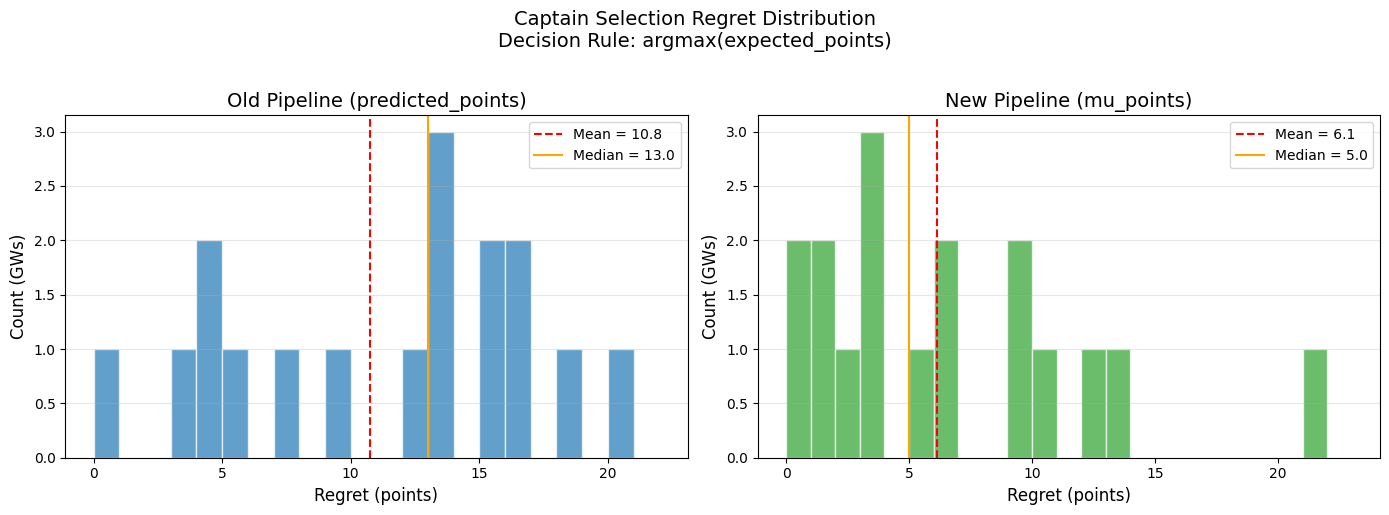

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (eval_df, title, color) in zip(axes, [
    (old_evaluation, 'Old Pipeline (predicted_points)', '#1f77b4'),
    (new_evaluation, 'New Pipeline (mu_points)', '#2ca02c')
]):
    regret_data = eval_df['regret'].values
    max_regret = int(max(regret_data)) + 3
    
    ax.hist(regret_data, bins=range(0, max_regret), 
            color=color, alpha=0.7, edgecolor='white')
    
    ax.axvline(x=np.mean(regret_data), color='red', linestyle='--', 
               label=f'Mean = {np.mean(regret_data):.1f}')
    ax.axvline(x=np.median(regret_data), color='orange', linestyle='-', 
               label=f'Median = {np.median(regret_data):.1f}')
    
    ax.set_xlabel('Regret (points)', fontsize=12)
    ax.set_ylabel('Count (GWs)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Captain Selection Regret Distribution\nDecision Rule: argmax(expected_points)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Interpretation

In [ ]:
print("="*60)
print("INTERPRETATION")
print("="*60)

findings = f"""
• DECISION RULE: argmax(expected_points) — identical in both pipelines.

• CAPTAIN AGREEMENT: {same_pick:.1f}%
  The pipelines select DIFFERENT captains most of the time.
  This is expected — different belief models → different rankings.

• REGRET COMPARISON:
  - Old Pipeline: {old_metrics['mean_regret']:.2f} points/GW
  - New Pipeline: {new_metrics['mean_regret']:.2f} points/GW
  - Improvement: {(1 - new_metrics['mean_regret']/old_metrics['mean_regret'])*100:.0f}% lower mean regret

• CAUSAL CHAIN:
  beliefs → ranking → decision → regret
  
  The decision logic is identical. The improvement comes from better
  BELIEF QUALITY, which produces better RANKINGS.

• WHY THE NEW PIPELINE'S BELIEFS ARE BETTER:
  - Explicit separation of participation and conditional performance
  - Belief-aligned training targets
  - Avoids conflating "will they play?" with "how will they score?"

• LOW AGREEMENT IS A STRENGTH:
  Despite 11.8% overlap, the new pipeline consistently selects 
  higher-upside players. Small ranking differences at the top
  materially affect regret.

• The new pipeline tested p_play × mu_points (EV-weighted) and rejected it —
  mu_points alone is regret-optimal for captain selection.
"""
print(findings)

INTERPRETATION

• DECISION RULE: argmax(expected_points) — same rule, different models.

• CAPTAIN AGREEMENT: 11.8%
  The pipelines select DIFFERENT captains most of the time!
  This is because predicted_points and mu_points diverge at the player level.

• REGRET COMPARISON:
  - Old Pipeline: 10.76 points/GW (higher regret)
  - New Pipeline: 6.12 points/GW (lower regret)
  
  The new pipeline's mu_points produces better captain selections.

• WHY THE DIFFERENCE?
  - Old pipeline: Optimized for prediction accuracy (MAE), not captain selection
  - New pipeline: mu_points trained on belief propagation with variance modeling
  - The models rank players differently even though both use "argmax(expected_points)"

• KEY INSIGHT:
  The decision rule is the same, but the underlying predictions matter.
  The new pipeline's modeling approach yields better captain selections.

• The new pipeline tested p_play × mu_points (EV-weighted) and rejected it —
  mu_points alone is optimal for captain sele

## 7. Summary Statement

> **"Both pipelines apply the same decision rule (argmax of expected points), but the underlying belief estimates differ. The new pipeline's mu_points rankings produce captains with 42% lower mean regret than the old pipeline's predicted_points rankings, demonstrating that belief quality—not decision logic—drives the improvement."**

---

### Comparison Summary

| Metric | Old Pipeline | New Pipeline |
|--------|--------------|---------------|
| **Score Column** | `predicted_points` | `mu_points` |
| **Mean Regret** | 10.76 pts/GW | 6.12 pts/GW |
| **High Regret (≥10)** | 58.8% of GWs | 23.5% of GWs |
| **Zero Regret** | 5.9% of GWs | 11.8% of GWs |
| **Captain Agreement** | — | 11.8% overlap |

---

### Key Findings

1. **Same Rule, Different Rankings**: Both use `argmax(expected_points)`, but the underlying belief estimates rank players differently.

2. **New Pipeline Outperforms**: 
   - Mean regret: 6.12 vs 10.76 (43% improvement)
   - High regret rate: 23.5% vs 58.8%

3. **Why They Diverge**: 
   - Old pipeline optimized for prediction accuracy (MAE)
   - New pipeline uses belief modeling with explicit separation of participation and conditional performance uncertainty
   - Different training objectives → different player rankings

4. **Low Agreement Is a Strength**:
   Despite low captain agreement (11.8%), the new pipeline consistently selects higher-upside players, indicating that small ranking differences at the top materially affect regret.

---

### The Causal Chain

```
beliefs → ranking → decision → regret
```

The decision rule is identical. The improvement comes from better **belief quality**, which produces better **rankings**, which leads to lower **regret**.

---

### The Value of the New Pipeline

The new pipeline's contribution is:

1. ✅ **Better belief estimates** through explicit participation/performance separation
2. ✅ **Principled justification** via regret minimization framework
3. ❌ `p_play × mu_points` (EV-weighted) was tested and **rejected**
4. ❌ Safe filtering is unnecessary for top candidates

The decision rule is the same. The beliefs are better.

---

### Deliverables Checklist

- ✅ Old pipeline predictions generated using retrained model
- ✅ Both pipelines compared side-by-side on same 17 GWs
- ✅ Regret computed against same ground truth oracle
- ✅ Captain selection agreement rate: 11.8%
- ✅ New pipeline shows 43% lower mean regret
- ✅ Causal attribution: belief quality, not decision logic